# NLRP3
For most of details, please refer to the hsp90 notebook.

In [1]:
import numpy as np 
import pandas as pd
import os 
from scipy.spatial import distance
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
import seaborn as sns

# Use cryodrgn env
from cryodrgn import utils
from cryodrgn import analysis
from cryodrgn import fft, mrc

import umap

# Graph traversal
from heapq import heappush, heappop
import torch

/home/danlin/anaconda3/envs/cryodrgn/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/danlin/anaconda3/envs/cryodrgn/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/danlin/anaconda3/envs/cryodrgn/lib/python3.10/site-packages/

In [2]:
def get_nearest_point(data, query):
    '''
    Find closest point in @data to @query
    Return index 
    '''
    ind = cdist(query, data).argmin(axis=1)
    return ind

In [3]:
##### MOTIFY THIS PART WHILE DOING OTHER EXPERIMENTs #####
def cal_state_label(CM1, CM2, CM3):
    label = 400*(CM1-1)+20*(CM2-1)+CM3
    return label

def get_ground_truth_labels(occ, n_PDs):
    '''
    Calculate ground truth label for each center.
    Since when we create MRC clones are use the order of occ[i][j], 
    the ground truth label would start at CM2 firest. 
    e.g. state_01_01 -> state_01_02 -> ... -> state_05_05 clone 5 times -> ...
    And each MRC would have N PDs images 
    '''
    n_confs = occ.shape[0]**3 # 20x20x20 CMs in NRLP3 experiment
    occ_list = occ.T.flatten().astype(int) # equivalent to occ[i][j]
    ground_truth_labels = np.repeat(np.repeat(np.arange(1,n_confs+1), occ_list), n_PDs)
    return ground_truth_labels

def get_centers_and_path(z, ground_truth_labels):
    '''
    In hsp90 experiment, state1:(5,5,6), state2(15,15,15), transition:(15,15,6)
    '''
    state1 = ground_truth_labels==cal_state_label(5,5,6)
    state2 = ground_truth_labels==cal_state_label(15,15,15)
    transition_state = ground_truth_labels==cal_state_label(15,15,6)

    center1 = get_nearest_point(z, [np.mean(z[state1], axis=0)])[0]
    center2 = get_nearest_point(z, [np.mean(z[state2], axis=0)])[0]
    transition = get_nearest_point(z, [np.mean(z[transition_state], axis=0)])[0]

    path1_label = cal_state_label(np.arange(5,16), np.arange(5,16), 6)
    path1 = []
    for i in path1_label:
        path1.append(get_nearest_point(z, [np.mean(z[ground_truth_labels==i], axis=0)])[0])
    path2_label = cal_state_label(15,15, np.arange(6,15+1))
    path2 = []
    for i in path2_label:
        path2.append(get_nearest_point(z, [np.mean(z[ground_truth_labels==i], axis=0)])[0])

    truth_path = path1 + path2

    return state1, state2, transition_state, center1, center2, transition, truth_path
#######################################################

# 1. Get the Labels

In [4]:
workdir =  "/mnt/d/energy_aware_pathfinding//nlrp3"
# load ground trouth occupancy map
occ = np.load(f"{workdir}/nlrp3_noise_3778.npy")
# load training outputs
z = utils.load_pkl(f"{workdir}/z_8/z.49.pkl")

# output dir
pathdir = f"{workdir}/paths"
if not os.path.exists(pathdir):
    os.mkdir(pathdir)

In [5]:
n_PDs = 20
ground_truth_label = get_ground_truth_labels(occ, n_PDs)
state1, state2, transition_state, center1, center2, transition, truth_path = get_centers_and_path(z, ground_truth_label)

# 2. Embedding (densMAP)

In [6]:
dens_emb = umap.UMAP(
    n_components=2,
    n_neighbors=15,
    min_dist=0.1,
    learning_rate=1e-3,
    densmap=True,
    dens_frac=0.7,
    dens_lambda=3,
    random_state=915
).fit_transform(z)

np.save(f'{workdir}/dens_emb.npy', dens_emb)

# 3. Graph Traversal

In [7]:
# This class can be found at 
# https://github.com/zhonge/cryodrgn/blob/master/cryodrgn/commands/graph_traversal.py

class Graph(object):
    def __init__(self, edges):  # edges is a list of tuples (src, dest, distance)
        # everything after here is derived from (weights, actions, probs)
        # for computational efficiency

        # FIXME: nodes and goal nodes should be the same
        self.nodes = set([x[0] for x in edges] + [x[1] for x in edges])
        self.edges = {x: set() for x in self.nodes}
        self.edge_length = {}
        for s, d, L in edges:
            assert type(s) == int and type(d) == int and type(L) == float
            self.edges[s].add(d)
            self.edge_length[(s, d)] = L

    def find_path(self, src, dest):
        visited = set()
        unvisited = []
        distances = {}
        predecessors = {}

        distances[src] = 0
        heappush(unvisited, (0, src))

        while unvisited:
            # visit the neighbors
            dist, v = heappop(unvisited)
            if v in visited or v not in self.edges:
                continue
            visited.add(v)
            if v == dest:
                # We build the shortest path and display it
                path = []
                pred = v
                while pred is not None:
                    path.append(pred)
                    pred = predecessors.get(pred, None)
                return path[::-1], dist

            neighbors = list(self.edges[v])

            for idx, neighbor in enumerate(neighbors):
                if neighbor not in visited:
                    new_distance = dist + self.edge_length[(v, neighbor)]
                    if new_distance < distances.get(neighbor, float("inf")):
                        distances[neighbor] = new_distance
                        heappush(unvisited, (new_distance, neighbor))
                        predecessors[neighbor] = v
            
        # couldn't find a path
        return None, None

In [8]:
def construct_grpah(z, max_neighbors, use_cuda=True):
    '''
    constrcut a knn graph from latent variables
    '''
    data = torch.from_numpy(z)
    if use_cuda:
        device = torch.device("cuda")
    else:
        device = torch.device("cpu") 
    data = data.to(device)

    N, D = data.shape
    B = 5000 # batch size, set to lower value if GPU memory limit.
    n2 = (data * data).sum(-1, keepdim=True)

    ndist = torch.empty(data.shape[0], max_neighbors, device=device)
    neighbors = torch.empty(
        data.shape[0], max_neighbors, dtype=torch.long, device=device
    )

    for i in range(0, data.shape[0], B):
        # (a-b)^2 = a^2 + b^2 - 2ab
        #print(f"Working on images {i}-{i+B}")
        batch_dist = n2[i : i + B] + n2.t() - 2 * torch.mm(data[i : i + B], data.t())
        ndist[i : i + B], neighbors[i : i + B] = batch_dist.topk(
            max_neighbors, dim=-1, largest=False
        )

    ndist = ndist.clamp(min=0).pow(0.5)
    return ndist, neighbors

def default_graph_travseral(ndist, neighbors, anchors, pathdir):
    '''
    perform graph traversal in default parameters, 
    searhing through anchors(a list of data points index)
    '''
    # pruning the graph
    N = neighbors.shape[0]
    avg_neighbors = 5
    total_neighbors = int(N * avg_neighbors)
    max_dist = ndist.view(-1).topk(total_neighbors, largest=False)[0][-1]

    max_dist = max_dist.to("cpu")
    neighbors = neighbors.to("cpu")
    ndist = ndist.to("cpu")

    edges = []
    for i in range(neighbors.shape[0]):
        for j in range(neighbors.shape[1]):
            if max_dist is None or ndist[i, j] < max_dist:
                edges.append((int(i), int(neighbors[i, j]), float(ndist[i,j])))

    # searching
    graph = Graph(edges)
    full_path = []
    for i in range(len(anchors)-1):
        src, dest = anchors[i], anchors[i+1]
        path, _ = graph.find_path(src, dest)
        
        if path is not None:
            if full_path and full_path[-1] == path[0]:
                full_path.extend(path[1:])
            else:
                full_path.extend(path)
        else: 
            full_path.append(None)
    
    # save the results
    np.savetxt(f'{pathdir}/default.txt', full_path)
    return full_path

In [9]:
ndist, neighbors = construct_grpah(z, max_neighbors=10)
default_gt = default_graph_travseral(ndist, neighbors, anchors=[center1, center2], pathdir=pathdir)

## GT-q

In [10]:
def euclidean_weights_searching(ndist, neighbors, quantile_list, anchors):
    '''
    Try to searching the threshold for a given knn graph in graph traversal framework
    '''
    path_list = []
    for q in quantile_list:
        #print(f'Working on quantile={q}')   
        # pruning 
        max_dist = torch.quantile(ndist, q=q)
        max_dist = max_dist.to("cpu")
        neighbors = neighbors.to("cpu")
        ndist = ndist.to("cpu")

        edges = []
        for i in range(neighbors.shape[0]):
            for j in range(neighbors.shape[1]):
                if max_dist is None or ndist[i, j] < max_dist:
                    edges.append((int(i), int(neighbors[i, j]), float(ndist[i,j])))

        # searching
        graph = Graph(edges)
        full_path = []
        for i in range(len(anchors)-1):
            src, dest = anchors[i], anchors[i+1]
            path, _ = graph.find_path(src, dest)
            
            if path is not None:
                if full_path and full_path[-1] == path[0]:
                    full_path.extend(path[1:])
                else:
                    full_path.extend(path)
            else: 
                full_path.append(None)
        path_list.append(full_path)

    return path_list

def plot_searching_results(emb, labels, centers, paths, quantile_list):
    '''
    plot the euclidean threshold searching results
    '''
    state_legend = ["State1", "State2", "Transition state"]
    plt.figure(figsize=(15,15))
    plt.scatter(emb[:,0], emb[:,1], s=0.5, alpha=0.5)
    for i, state in enumerate(labels):
        plt.scatter(emb[state][:,0], emb[state][:,1], s=5, label=f"{state_legend[i]}", zorder=1)

    cmap = plt.cm.get_cmap('tab20b')
    for i, path in enumerate(paths):
        if None in path:
            print(f"q={quantile_list[i]}  can not find the path")
        else:
            color = cmap(i/(len(quantile_list)-1))
            plt.plot(emb[path][:,0], emb[path][:,1], '-o', 
                     markersize=5, color=color,label=f"q={quantile_list[i]}")
            
    plt.scatter(emb[centers][:,0], emb[centers][:,1], s=10, c='w', zorder=3)
    plt.legend()
    plt.show()

def euclidean_weights_searching(ndist, neighbors, quantile_list, anchors):
    '''
    Try to searching the threshold for a given knn graph in graph traversal framework
    '''
    path_list = []
    for q in quantile_list:
        #print(f'Working on quantile={q}')   
        # pruning 
        max_dist = torch.quantile(ndist, q=q)
        max_dist = max_dist.to("cpu")
        neighbors = neighbors.to("cpu")
        ndist = ndist.to("cpu")

        edges = []
        for i in range(neighbors.shape[0]):
            for j in range(neighbors.shape[1]):
                if max_dist is None or ndist[i, j] < max_dist:
                    edges.append((int(i), int(neighbors[i, j]), float(ndist[i,j])))

        # searching
        graph = Graph(edges)
        full_path = []
        for i in range(len(anchors)-1):
            src, dest = anchors[i], anchors[i+1]
            path, _ = graph.find_path(src, dest)
            
            if path is not None:
                if full_path and full_path[-1] == path[0]:
                    full_path.extend(path[1:])
                else:
                    full_path.extend(path)
            else: 
                full_path.append(None)
        path_list.append(full_path)

    return path_list

def plot_searching_results(emb, labels, centers, paths, quantile_list):
    '''
    plot the euclidean threshold searching results
    '''
    state_legend = ["State1", "State2", "Transition state"]
    plt.figure(figsize=(15,15))
    plt.scatter(emb[:,0], emb[:,1], s=0.5, alpha=0.5)
    for i, state in enumerate(labels):
        plt.scatter(emb[state][:,0], emb[state][:,1], s=5, label=f"{state_legend[i]}", zorder=1)

    cmap = plt.cm.get_cmap('tab20b')
    for i, path in enumerate(paths):
        if None in path:
            print(f"q={quantile_list[i]}  can not find the path")
        else:
            color = cmap(i/(len(quantile_list)-1))
            plt.plot(emb[path][:,0], emb[path][:,1], '-o', 
                     markersize=5, color=color,label=f"q={quantile_list[i]}")
            
    plt.scatter(emb[centers][:,0], emb[centers][:,1], s=10, c='w', zorder=3)
    plt.legend()
    plt.show()

def save_the_best_threshold(ndist, paths, quantile_list, pathdir, eng=False, plot=True):
    '''
    Save the best threshold based on the average distance metric
    for the output path p_1, p_2, ..., p_q and its neighbors p_j (N is the number of negibhors)
    (1/q)\sum_{i=1}^q(\sum_{j}||p_i-p_j||/N)
    '''
    metric_ = []
    for i, path in enumerate(paths):
        if None in path:
            metric_.append(None)
        else:
            max_dist = torch.quantile(ndist, quantile_list[i])
            mean_below_threshold = (ndist * (ndist < max_dist).float()).sum(dim=1) / (ndist < max_dist).sum(dim=1).clamp(min=1)
            metric_.append(torch.mean(mean_below_threshold[path]).to("cpu"))

    # save the lowest
    metric = [x for x in metric_ if x is not None]
    min_index = metric_.index(min(metric))
    if eng:
        np.savetxt(f'{pathdir}/eng.txt', paths[min_index])
    else:
        np.savetxt(f'{pathdir}/quantile.txt', paths[min_index])

    # plot
    if plot:
        plt.plot(quantile_list, metric_, "-o")
        plt.xlabel('quantile')
        plt.ylabel('mean of avg_dist')
        plt.show

In [11]:
ndist, neighbors = construct_grpah(z, max_neighbors=10)
toy_quantiles = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
toy_paths = euclidean_weights_searching(ndist, neighbors, 
                                       quantile_list=toy_quantiles, anchors=[center1, center2])

/tmp/ipykernel_13206/686637861.py:108: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab20b')


q=0.1  can not find the path
q=0.2  can not find the path


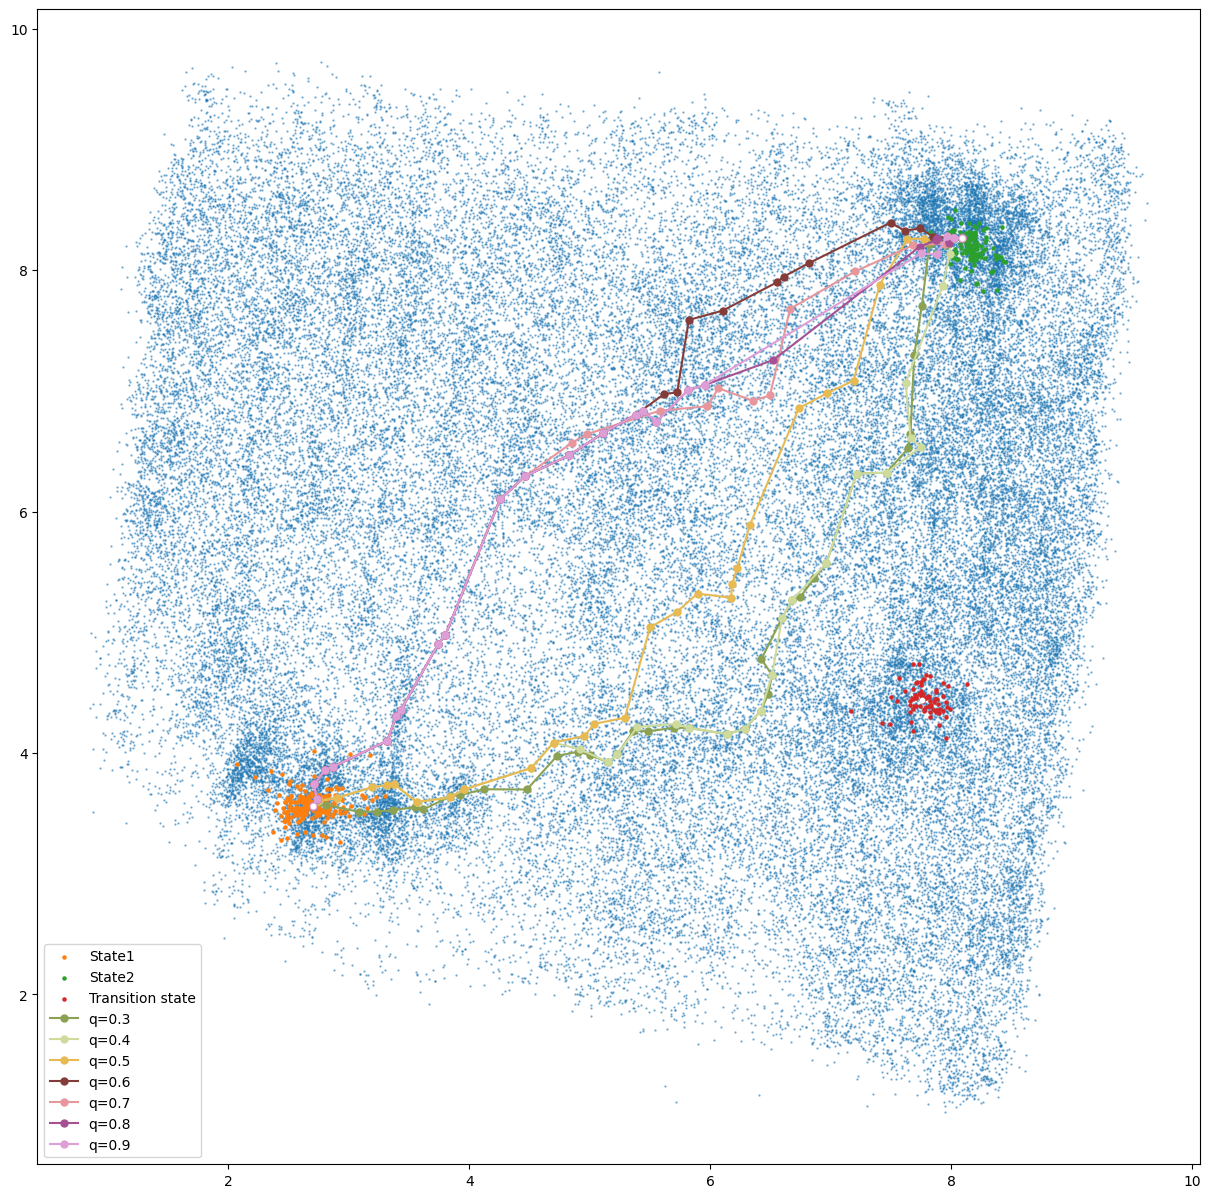

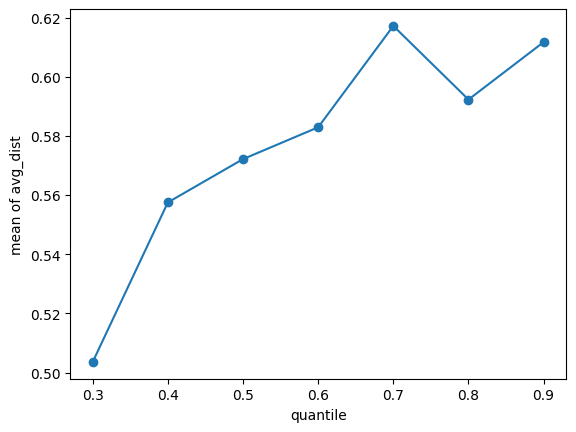

In [12]:
plot_searching_results(emb=dens_emb, 
                       labels=[state1, state2, transition_state], 
                       centers=[center1, center2, transition],
                       paths=toy_paths,
                       quantile_list=toy_quantiles)

save_the_best_threshold(ndist, toy_paths, toy_quantiles, pathdir=pathdir, eng=False, plot=True)

# 4. Our method

In [13]:
def energy_weights_searching(ndist, neighbors, quantile_list, anchors, lowest_ratio=0.01, highest_ratio=0.1):
    '''
    Defined the edge weights as free-energy
    '''
    path_list = []
    N, max_neighbors = neighbors.shape
    for q in quantile_list:
        max_dist = torch.quantile(ndist, q=q)
        # calculate free energy = -log(n_i/n_max)
        grids_counts = (ndist <= max_dist).sum(dim=1)
        eng = -torch.log(grids_counts/grids_counts.max())
        eng[eng==-0.] = 0.

        # control the the ratio of zero energy 
        states, counts = torch.unique(eng, return_counts=True)
        zero_energy_ratio = counts[0]/N
        if states.shape[0] <2 or zero_energy_ratio>highest_ratio or zero_energy_ratio<lowest_ratio:
            print(f'q={q} are not suitable.')
            path_list.append([None])

        else:
            neighbors = neighbors.to("cpu")
            ndist = ndist.to("cpu")
            eng = eng.to("cpu")

            eng_dist = torch.empty(N, max_neighbors, dtype=eng.dtype)
            for i in range(N):
                # get the indices of the neighbors for the current point
                neighbor_indices = neighbors[i]
                # use the indices to retrieve the values of the neighbors from the value vector
                eng_dist[i] = (eng[neighbor_indices]+eng[i])/2.
            eng_dist = eng_dist.to("cpu")

            edges_eng = []
            for i in range(neighbors.shape[0]):
                for j in range(neighbors.shape[1]):
                    edges_eng.append((int(i), int(neighbors[i, j]), float(eng_dist[i,j])))

            # searching
            graph = Graph(edges_eng)
            full_path = []
            for i in range(len(anchors)-1):
                src, dest = anchors[i], anchors[i+1]
                path, _ = graph.find_path(src, dest)
                
                if path is not None:
                    if full_path and full_path[-1] == path[0]:
                        full_path.extend(path[1:])
                    else:
                        full_path.extend(path)
                else: 
                    full_path.append([None])
            path_list.append(full_path)
    return path_list

In [14]:
ndist, neighbors = construct_grpah(z, max_neighbors=50)
toy_quantiles = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
toy_paths = energy_weights_searching(ndist, neighbors, 
                                     quantile_list=toy_quantiles, anchors=[center1, center2])

q=0.1 are not suitable.
q=0.4 are not suitable.
q=0.5 are not suitable.
q=0.6 are not suitable.
q=0.7 are not suitable.
q=0.8 are not suitable.
q=0.9 are not suitable.


/tmp/ipykernel_13206/686637861.py:108: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab20b')


q=0.1  can not find the path
q=0.4  can not find the path
q=0.5  can not find the path
q=0.6  can not find the path
q=0.7  can not find the path
q=0.8  can not find the path
q=0.9  can not find the path


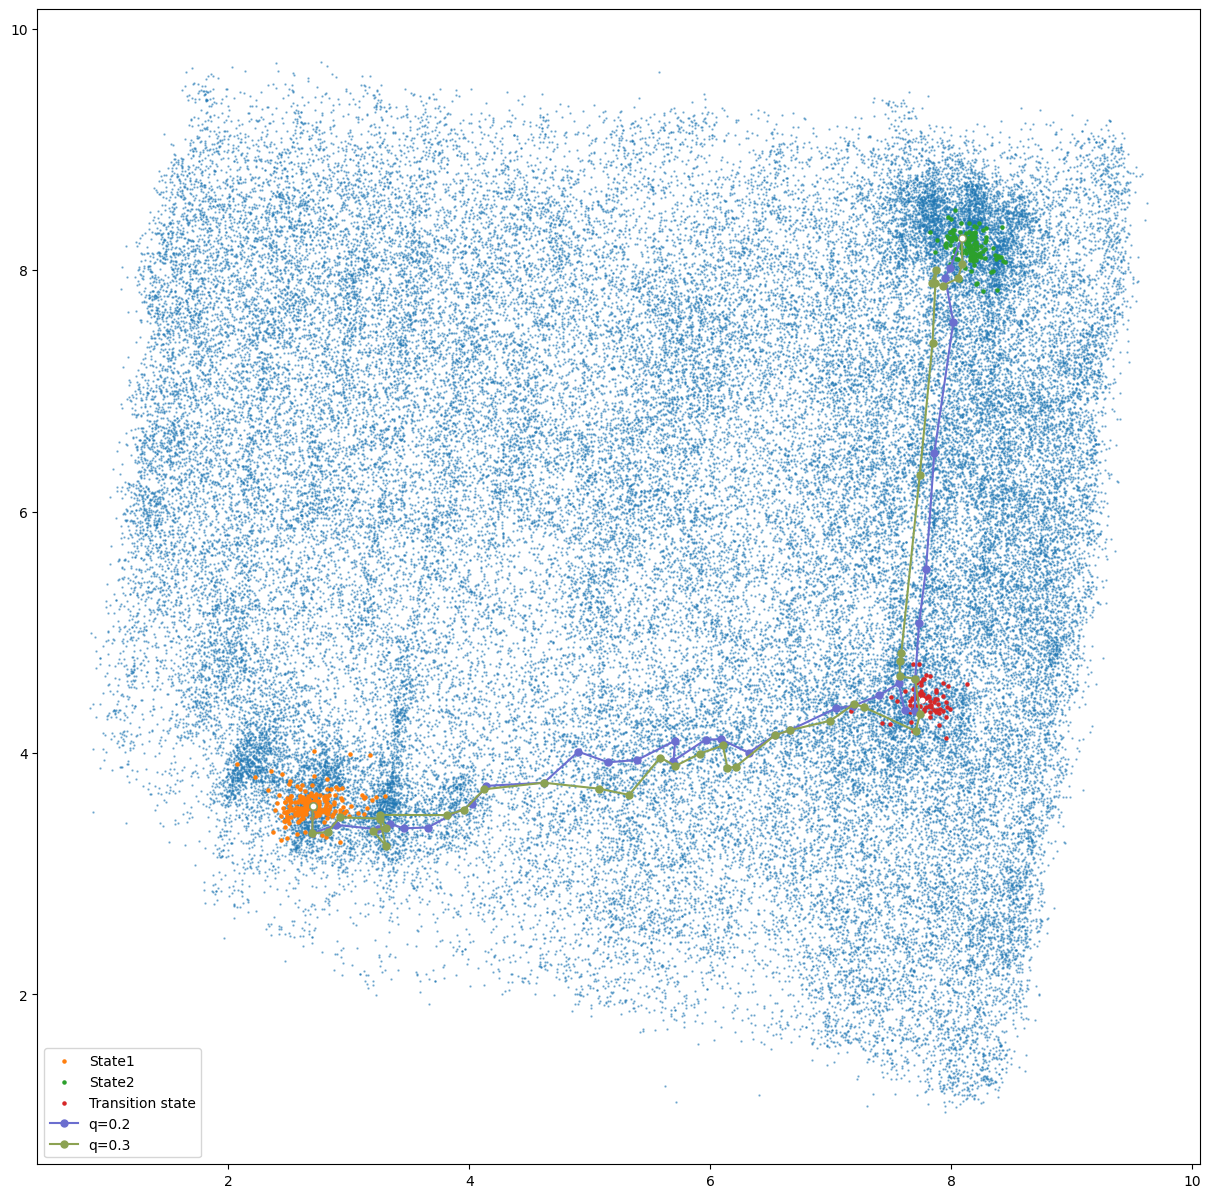

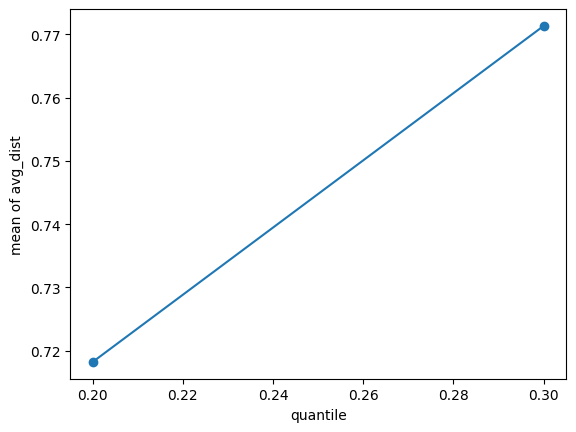

In [15]:
plot_searching_results(emb=dens_emb, 
                       labels=[state1, state2, transition_state], 
                       centers=[center1, center2, transition],
                       paths=toy_paths,
                       quantile_list=toy_quantiles)

save_the_best_threshold(ndist, toy_paths, toy_quantiles, pathdir=pathdir, eng=True, plot=True)

# Implement POLARIS

## Convert to 2D energy landsacpe

In [16]:
def free_energy(emb, n_states):
    '''
    Convert to energy landscape based on bins-count appraoch.
    '''
    grids, _ = np.histogramdd(emb, bins=(n_states+1, n_states+1)) # n+1 bins to cut n cells
    grids = grids.T
    # Energy
    occmax = np.amax(grids)
    E = -np.log(grids/occmax)
    E[E==np.inf] = np.unique(E)[-2] + 0.00001 # replace -inf to second lowest energy plus constant.
    return E

def points_for_polaris(emb, n_states, list_idx):
    '''
    Convert the starting and ending point index in to the location in 2D energy landscape.
    '''
    x = emb[:,0][list_idx]
    y = emb[:,1][list_idx]
    n_cells_x = np.linspace(emb[:,0].min(), emb[:,0].max(), n_states+1)
    n_cells_y = np.linspace(emb[:,1].min(), emb[:,1].max(), n_states+1)
    x = np.digitize(x, n_cells_x) -1
    y = np.digitize(y, n_cells_y) -1
    return np.stack((x,y), axis=1)

/tmp/ipykernel_13206/1071592916.py:9: RuntimeWarning: divide by zero encountered in log
  E = -np.log(grids/occmax)


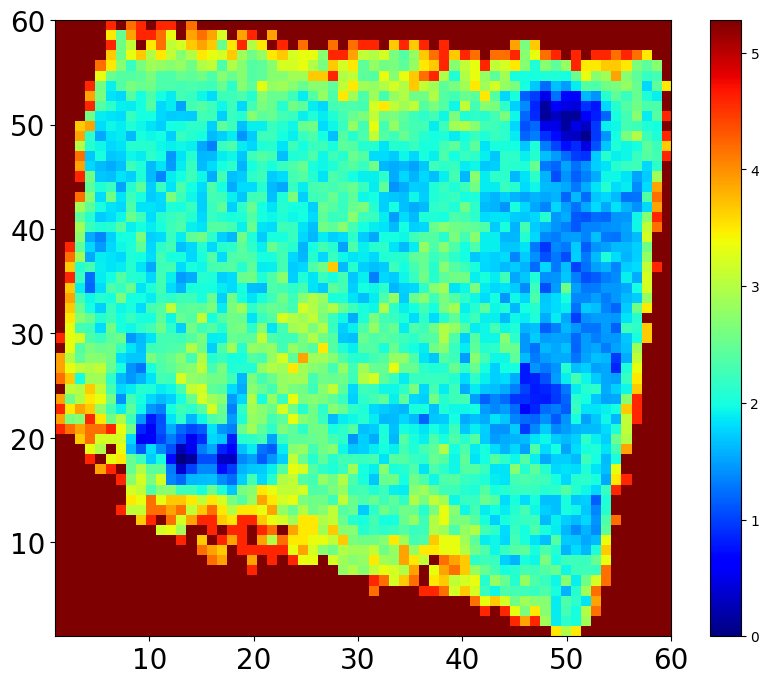

Start:[12 17], End:[49 49]


In [17]:
# load densMAP result
dens_emb = np.load(f'{workdir}/dens_emb.npy')
# output dir for 2D energy landsacpe
engdir = "/home/danlin/POLARIS/data_input/"

eng = free_energy(dens_emb, n_states=60)
plt.figure(figsize=(10,8))
plt.imshow(eng, origin='lower', extent=[1,60,1,60], cmap='jet')
plt.colorbar()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()

np.savetxt(f'{engdir}/nlrp3.txt', eng)
pol_input = points_for_polaris(dens_emb, n_states=60, list_idx=[center1, center2])
print(f'Start:{pol_input[0,:]}, End:{pol_input[1,:]}')

## After searching

In [18]:
def save_polaris_result(emb, path, pathdir, n_states=60):
    ''' 
    After searching MEP using POLARIS, convert the path location in 2D back to data point index
    '''
    # Create the bin edges
    n_cells_x = np.linspace(emb[:,0].min(), emb[:,0].max(), n_states + 1)
    n_cells_y = np.linspace(emb[:,1].min(), emb[:,1].max(), n_states + 1)
    # Calculate the center of each bin
    centers_x = (n_cells_x[:-1] + n_cells_x[1:]) / 2
    centers_y = (n_cells_y[:-1] + n_cells_y[1:]) / 2
    # energy coordiante -> embedding space coordinate
    emb_x = centers_x[path[:, 0].astype(int)]
    emb_y = centers_y[path[:, 1].astype(int)]
    polaris_2d = np.stack((emb_x, emb_y), axis=1)
    # embedding space coordinate -> nearest point index 
    polaris_path = get_nearest_point(emb, polaris_2d)
    np.savetxt(f'{pathdir}/polaris.txt', polaris_path)

In [19]:
polaris_result = np.loadtxt(f'{workdir}/polaris/polaris_output.txt', skiprows=9, usecols=(0, 1)) #only keep x and y coodrinate
save_polaris_result(emb=dens_emb, path=polaris_result, pathdir=pathdir, n_states=60)

# Comparsion and Evaulation

In [20]:
# Load results
z = utils.load_pkl(f'{workdir}/z_8/z.49.pkl')
dens_emb = np.load(f'{workdir}/dens_emb.npy')

default_path = np.loadtxt(f'{workdir}/paths/default.txt').astype(int)
quantile_path = np.loadtxt(f'{workdir}/paths/quantile.txt').astype(int)
eng_path = np.loadtxt(f'{workdir}/paths/eng.txt').astype(int)
polaris_path = np.loadtxt(f'{workdir}/paths/polaris.txt').astype(int)

## Viz

In [21]:
def plot_results(emb, labels, centers, paths):
    '''
    plot the embedding results with the color of each conformational state 
    and the center of each state(black dpt).
    '''
    state_legend = ["Start", "End", "Transition state"]
    state_colors = ['tab:orange', 'tab:green', 'tab:red']
    path_legend = ["Ground truth label centers", 
                "Graph traversal", 
                "Graph traversal (quantile search)", 
                "Our method ", 
                "Searching on 2D energy landscape"]
    path_colors= ['k', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray']

    plt.figure(figsize=(10, 8))
    plt.scatter(emb[:, 0], emb[:, 1], s=0.5, alpha=0.25) #densMAP
    for i, state in enumerate(labels):
        plt.scatter(emb[state][:, 0], emb[state][:, 1], s=2, alpha=0.5, c=state_colors[i], zorder=1) #states

    for i, path in enumerate(paths):
        plt.plot(
            emb[path][:, 0], emb[path][:, 1], '-o',
            markersize=5, c=path_colors[i], zorder=2
        ) #paths

    plt.scatter(emb[centers][:, 0], emb[centers][:, 1], s=1, c='w', zorder=3) #white dot for three centers
    plt.xlabel("densMAP 1", fontsize=20)
    plt.ylabel("densMAP 2", fontsize=20)
    plt.show()

    # legend plot
    fig_legend_combined = plt.figure(figsize=(5, 3))  
    axi = fig_legend_combined.add_subplot(111)
    axi.axis('off')
    lines_states = [plt.Line2D([0], [0], color=c, marker='o', linestyle='', markersize=10) for c in state_colors]
    lines_paths = [plt.Line2D([0], [0], color=c, linewidth=2, marker='o', markersize=10) for c in path_colors] 
    combined_lines = lines_states + lines_paths
    combined_labels = state_legend + path_legend
    fig_legend_combined.legend(combined_lines, combined_labels, fontsize=20, loc='center')
    plt.show()

def closest_to_transition(z, path, transition_idx):
    '''
    Find the point in the path which is closest to the transtion state center
    '''
    nearest_point = None
    nearest_distance = float('inf')
    for indx, points in enumerate(z[path]):
        d = distance.euclidean(z[transition_idx], points)
        if d < nearest_distance:
            nearest_point = indx
            nearest_distance = d
    return path[nearest_point], nearest_distance

def plot_cloest_point(emb, points_list):
    '''
    Plot the cloest point with transition state center in embedding space
    '''
    color_list = ['k', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray']
    plt.figure(figsize=(10,8))
    plt.scatter(emb[:,0], emb[:,1], s=0.01)
    for i, point in enumerate(points_list):
        plt.scatter(emb[point, 0], emb[point, 1], s=100, c=color_list[i])
    plt.xlabel("densMAP 1", fontsize=20)
    plt.ylabel("densMAP 2", fontsize=20)
    plt.show()

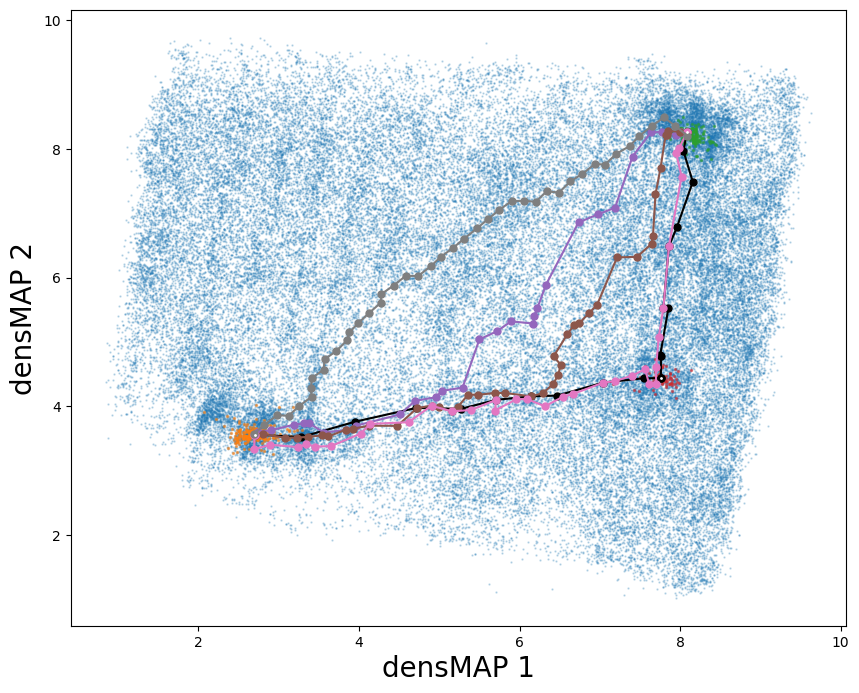

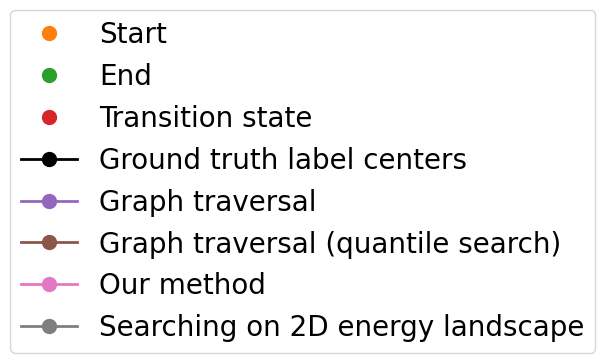

In [22]:
n_PDs = 20
ground_truth_label = get_ground_truth_labels(occ, n_PDs)
state1, state2, transition_state, center1, center2, transition, truth_path = get_centers_and_path(z, ground_truth_label)

plot_results(emb=dens_emb,
             labels=[state1, state2, transition_state],
             centers=[center1, center2, transition],
             paths=[truth_path, default_path, quantile_path, eng_path, polaris_path])

Default 3.6888930797576904 Quantile 2.915078639984131 Energy 0.6023712158203125 POLARIS 3.2647173404693604


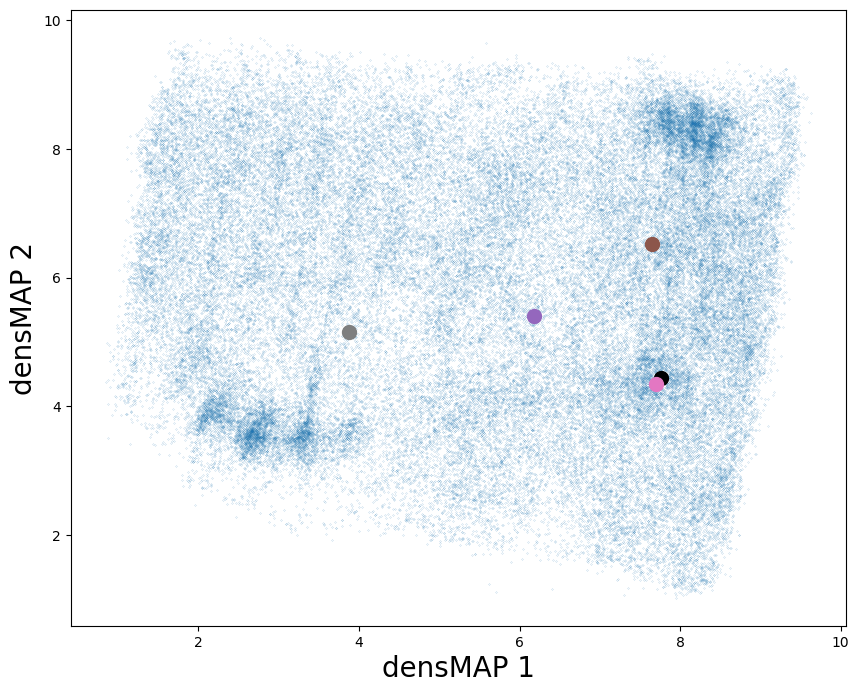

In [23]:
default_vol_idx, default_d = closest_to_transition(z, default_path, transition)
quantile_vol_idx, quantile_d = closest_to_transition(z, quantile_path, transition)
eng_vol_idx, eng_d = closest_to_transition(z, eng_path, transition)
polaris_vol_idx, polaris_d = closest_to_transition(z, polaris_path, transition)
print("Default",default_d, "Quantile",quantile_d, "Energy",eng_d, "POLARIS", polaris_d)
plot_cloest_point(
    dens_emb, 
    [transition, default_vol_idx, quantile_vol_idx, eng_vol_idx, polaris_vol_idx]
)

## FSC

In [24]:
def generate_volumes(zvalues, zdir, outdir, **kwargs):
    '''
    Helper function to call cryodrgn eval_vol and generate new volumes
    '''
    if not os.path.exists(outdir):
        os.mkdir(outdir)
    np.savetxt(f'{outdir}/zfile.txt', zvalues)
    analysis.gen_volumes(weights=f'{zdir}/weights.49.pkl',
                         config=f'{zdir}/config.pkl',
                         zfile=f'{outdir}/zfile.txt',
                         outdir=f'{outdir}', **kwargs)
    return print(f'vol in {outdir}/')

def cal_fsc(vol1, vol2):
    '''
    Calculate fsc.
    (From cryoDRGN)
    '''
    D = vol1.shape[0]
    x = np.arange(-D // 2, D // 2)
    x2, x1, x0 = np.meshgrid(x, x, x, indexing="ij")
    coords = np.stack((x0, x1, x2), -1)
    r = (coords**2).sum(-1) ** 0.5

    assert r[D // 2, D // 2, D // 2] == 0.0

    vol1 = fft.fftn_center(vol1)
    vol2 = fft.fftn_center(vol2)

    prev_mask = np.zeros((D, D, D), dtype=bool)
    fsc = [1.0]
    for i in range(1, D // 2):
        mask = r < i
        shell = np.where(mask & np.logical_not(prev_mask))
        v1 = vol1[shell]
        v2 = vol2[shell]
        p = np.vdot(v1, v2) / (np.vdot(v1, v1) * np.vdot(v2, v2)) ** 0.5
        fsc.append(float(p.real))
        prev_mask = mask
    fsc = np.asarray(fsc)
    x = np.arange(D // 2) / D

    res = np.stack((x, fsc), 1)
    return res

def cal_resolution(fsc, threshold=0.5):
    idx = np.abs(fsc[:,1] - threshold).argmin()
    return 1/fsc[idx,0]

def plot_fsc_comparsion(x, fsc_list):
    plt.figure(figsize=(10,8))
    color_list = ['k', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray']
    for i, fsc in enumerate(fsc_list):
        plt.plot(x, fsc, c=color_list[i])
    plt.axvline(x = 0.1, color = 'k', linestyle = '--')
    plt.xlabel("Frequency", fontsize=20)
    plt.ylabel("FSC", fontsize=20)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.show()

In [25]:
generate_volumes(zvalues=z[[transition, default_vol_idx, quantile_vol_idx, eng_vol_idx, polaris_vol_idx]],
                 zdir=f'{workdir}/z_8',
                 outdir=f'{workdir}/vols/',
                 Apix = 1)

(INFO) (eval_vol.py) (10-Aug-23 21:36:40) Use cuda True
(INFO) (eval_vol.py) (10-Aug-23 21:36:40) Namespace(weights='/mnt/d/energy_aware_pathfinding//nlrp3/z_8/weights.49.pkl', config='/mnt/d/energy_aware_pathfinding//nlrp3/z_8/config.pkl', o='/mnt/d/energy_aware_pathfinding/nlrp3/vols', device=None, prefix='vol_', verbose=False, z=None, z_start=None, z_end=None, n=10, zfile='/mnt/d/energy_aware_pathfinding//nlrp3/vols//zfile.txt', Apix=1.0, flip=False, invert=False, downsample=None, vol_start_index=0, norm=None, D=None, qlayers=None, qdim=None, zdim=None, encode_mode=None, players=None, pdim=None, enc_mask=None, pe_type=None, feat_sigma=None, pe_dim=None, domain=None, l_extent=None, activation='relu')
(INFO) (eval_vol.py) (10-Aug-23 21:36:40) Loaded configuration:


{'dataset_args': {'ctf': '/mnt/d/NLRP3/more_rmsd_5/ctf.pkl',
                  'datadir': None,
                  'do_pose_sgd': False,
                  'ind': None,
                  'invert_data': True,
                  'keepreal': False,
                  'norm': [0, 106.0067],
                  'particles': '/mnt/d/NLRP3/more_rmsd_5/NLRP3_20PDs_SNR01.mrcs',
                  'poses': '/mnt/d/NLRP3/more_rmsd_5/poses.pkl',
                  'window': True,
                  'window_r': 0.85},
 'lattice_args': {'D': 129, 'extent': 0.5, 'ignore_DC': True},
 'model_args': {'activation': 'relu',
                'domain': 'fourier',
                'enc_mask': 64,
                'encode_mode': 'resid',
                'feat_sigma': 0.5,
                'pdim': 256,
                'pe_dim': None,
                'pe_type': 'gaussian',
                'players': 3,
                'qdim': 256,
                'qlayers': 3,
                'zdim': 8},
 'seed': 26896}


/home/danlin/anaconda3/envs/cryodrgn/lib/python3.10/site-packages/cryodrgn/config.py:14: UserWarning: Loading configuration from a .pkl file is deprecated. Please save/load configurationas a .yaml file instead.
  warnings.warn(


(INFO) (eval_vol.py) (10-Aug-23 21:36:40) Generating 5 volumes
(INFO) (eval_vol.py) (10-Aug-23 21:36:40) [-0.3492277   0.99199063 -0.13003486  0.02130646  1.98789096  0.90580475
  1.56009614 -0.28842065]
(INFO) (eval_vol.py) (10-Aug-23 21:36:41) [ 1.12401068 -1.09341693 -0.05071865  0.82398129 -0.42287704  0.33944571
  1.03519344 -0.46136776]
(INFO) (eval_vol.py) (10-Aug-23 21:36:41) [ 0.12958689 -0.27402896  0.97687358 -0.24326047 -0.16061771  1.15405989
  1.26208723  0.48865312]
(INFO) (eval_vol.py) (10-Aug-23 21:36:42) [-0.1843994   0.60335255 -0.32726303 -0.08168336  1.9277215   1.04970276
  1.34282291 -0.54061627]
(INFO) (eval_vol.py) (10-Aug-23 21:36:42) [-1.40779161  0.52867377 -1.27189422  1.94907403  1.4285661   1.24925685
 -0.38887128 -0.55999267]
(INFO) (eval_vol.py) (10-Aug-23 21:36:43) Finished in 0:00:03.197349
vol in /mnt/d/energy_aware_pathfinding//nlrp3/vols//


In [26]:
vol_truth, _ = mrc.parse_mrc(f'{workdir}/vols/state_15_15_06_1.mrc')
vol_center, _ = mrc.parse_mrc(f'{workdir}/vols/vol_000.mrc')
vol_default, _ = mrc.parse_mrc(f'{workdir}/vols/vol_001.mrc')
vol_quantile, _ = mrc.parse_mrc(f'{workdir}/vols/vol_002.mrc')
vol_eng, _ = mrc.parse_mrc(f'{workdir}/vols/vol_003.mrc')
vol_polaris, _ = mrc.parse_mrc(f'{workdir}/vols/vol_004.mrc')

fsc_center = cal_fsc(vol_truth, vol_center)
fsc_default = cal_fsc(vol_truth, vol_default)
fsc_quantile = cal_fsc(vol_truth, vol_quantile)
fsc_eng = cal_fsc(vol_truth, vol_eng)
fsc_polaris = cal_fsc(vol_truth, vol_polaris)

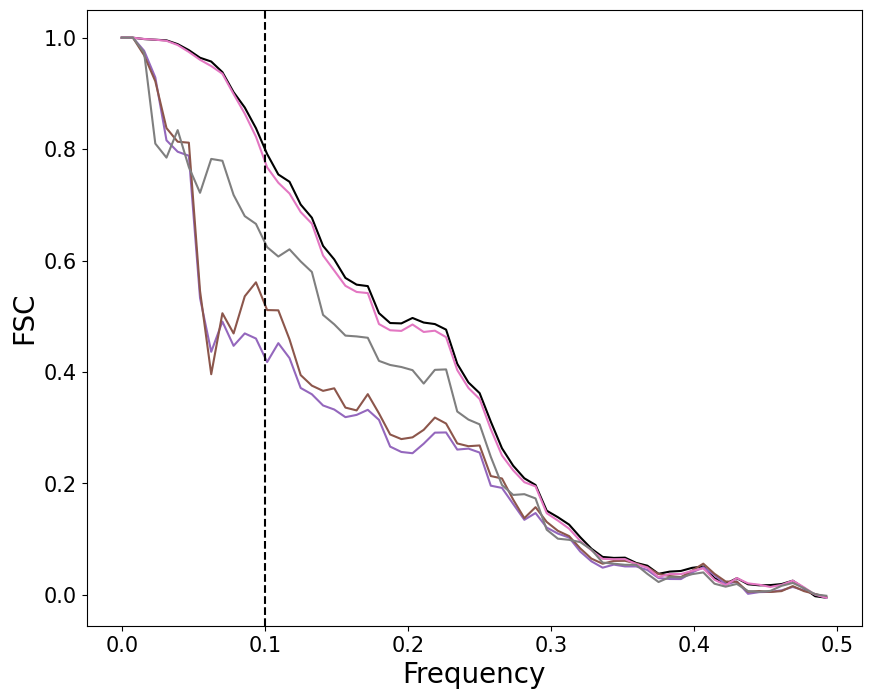

In [27]:
plot_fsc_comparsion(x=fsc_center[:,0],
                    fsc_list=[fsc_center[:,1], fsc_default[:,1], fsc_quantile[:,1], fsc_eng[:,1], fsc_polaris[:,1]])

In [28]:
print("Label center:", fsc_center[13,1])
print("GT:", fsc_default[13,1])
print("GT-q:", fsc_quantile[13,1])
print("MEP(2D):", fsc_polaris[13,1])
print("Our:", fsc_eng[13,1])

Label center: 0.79125366367501
GT: 0.4179150726755746
GT-q: 0.5112178725601356
MEP(2D): 0.6241740519675276
Our: 0.7673434659219024


## Distances

In [29]:
def ave_distance(z, truth, path):
    dis = []
    for i in truth:
        _, d = closest_to_transition(z, path, i)
        dis.append(d)
    return sum(dis)/(len(truth)-2)

def sum_distance(z, truth, path):
    dis = []
    for i in truth:
        _, d = closest_to_transition(z, path, i)
        dis.append(d)
    return sum(dis)

def hausdorff_distance(set1, set2):
  # Initialize maximum distance to 0
  max_distance_1 = 0
  
  # Iterate through points in set1
  for point1 in set1:
    # Find nearest point in set2
    nearest_point = None
    nearest_distance = float('inf')
    for point2 in set2:
      d = distance.euclidean(point1, point2)
      if d < nearest_distance:
        nearest_point = point2
        nearest_distance = d
    # Update maximum distance if necessary
    max_distance_1 = max(max_distance_1, nearest_distance)
  
  max_distance_2 = 0

  for point2 in set2:
    nearest_point = None
    nearest_distance = float('inf')

    for point1 in set1:
      d = distance.euclidean(point1, point2)
      if d < nearest_distance:
        nearest_point = point1
        nearest_distance = d
    
    max_distance_2 = max(max_distance_2, nearest_distance)

  max_distance = max(max_distance_1, max_distance_2)
  return max_distance

In [30]:
print("GT:",ave_distance(z, truth_path, default_path))
print("GT-q:",ave_distance(z, truth_path, quantile_path))
print("MEP(2D):",ave_distance(z, truth_path, polaris_path))
print("Our:",ave_distance(z, truth_path, eng_path))

GT: 2.0523528550800525
GT-q: 1.477138971027575
MEP(2D): 2.6364158329210783
Our: 0.5871788169208326


In [31]:
print("GT:",sum_distance(z, truth_path, default_path))
print("GT-q:",sum_distance(z, truth_path, quantile_path))
print("MEP(2D):",sum_distance(z, truth_path, polaris_path))
print("Our:",sum_distance(z, truth_path, eng_path))

GT: 38.994704246520996
GT-q: 28.065640449523926
MEP(2D): 50.09190082550049
Our: 11.156397521495819


In [32]:
print("GT:",hausdorff_distance(z[truth_path], z[default_path]))
print("GT-q:",hausdorff_distance(z[truth_path], z[quantile_path]))
print("MEP(2D):",hausdorff_distance(z[truth_path], z[polaris_path]))
print("Our:",hausdorff_distance(z[truth_path], z[eng_path]))

GT: 3.6888930797576904
GT-q: 2.915078639984131
MEP(2D): 6.695896625518799
Our: 1.1541105508804321
